<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/GPT2_Gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install -q transformers datasets magic-timer

import torch

from datasets import Dataset, DatasetDict, load_dataset
from transformers import (GPT2LMHeadModel, GPT2TokenizerFast, pipeline, 
                          create_optimizer, get_linear_schedule_with_warmup)

from magic_timer import MagicTimer
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MANUAL_SEED  = 2711
def deterministic(rep=True):
    torch.manual_seed(MANUAL_SEED)
    if torch.cuda.is_available():
            torch.cuda.manual_seed(MANUAL_SEED)
            torch.cuda.manual_seed_all(MANUAL_SEED)
            torch.backends.cudnn.enabled = False 
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
            print(f'Experimento deterministico, seed: {MANUAL_SEED} -- ', end = '')
            print(f'Existe {torch.cuda.device_count()} GPU {torch.cuda.get_device_name(0)} disponível.')
    else:
        print('Device CPU')
deterministic()        

Experimento deterministico, seed: 2711 -- Existe 1 GPU Tesla T4 disponível.


In [2]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [14]:
data = load_dataset("CShorten/ML-ArXiv-Papers", split='train')
data

Dataset({
    features: ['Unnamed: 0', 'Unnamed: 0.1', 'title', 'abstract'],
    num_rows: 117592
})

Mean abstracts: 167.0


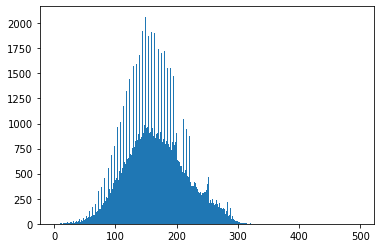

In [15]:
# Most of the abstracts are between about 100 and 250 words in length
abstracts = [len(x.split()) for x in data["abstract"]]
abstracts = torch.tensor(abstracts, dtype=torch.float)
print(f'Mean abstracts: {abstracts.mean().item():.4}')

# Select max len sequence (in tokens)
MAX_LEN = 300

plt.hist(abstracts, bins=400)
plt.show()

In [16]:
# Split dataset
data = data.train_test_split(shuffle=True, seed=MANUAL_SEED, test_size=0.1)
train = data["train"]
val   = data["test"]

# Tokenize data
train_token = train.map(
    lambda x: tokenizer(
        x["abstract"], 
        max_length=MAX_LEN,
        padding="max_length", 
        truncation=True), 
    batched=True,
    num_proc=os.cpu_count())

train_token = train_token.remove_columns(["title", "abstract", "Unnamed: 0", "Unnamed: 0.1"])

val_token = val.map(
    lambda x: tokenizer(
        x["abstract"], 
        max_length=MAX_LEN,
        padding="max_length", 
        truncation=True), 
    batched=True,
    num_proc=os.cpu_count()) 
    
val_token = val_token.remove_columns(["title", "abstract", "Unnamed: 0", "Unnamed: 0.1"])

In [17]:
""" In Casual Language Modeling, the labels are the input tokens (input_ids) right-shifted. 
This operation is automatically done by the Huggingface transformer thus I created a labels 
column in the datasets with a copy of the tokens (input_ids).

After this operation, the train and validation sets had three columns: 
input_ids and attention_mask from the tokenization process, and labels from the 
create_labels() process."""


# Create labels as a copy of input_ids
def create_labels(text):
    text["labels"] = text["input_ids"].copy()
    return text

# Add the labels column using map()
lm_train = train_token.map(create_labels, batched=True, num_proc=os.cpu_count())
lm_val = val_token.map(create_labels, batched=True, num_proc=os.cpu_count())

In [19]:
BSIZE = 12

lm_train.set_format(type='torch', output_all_columns=True)
lm_val.set_format(type='torch', output_all_columns=True)

train_loader = torch.utils.data.DataLoader(
    lm_train, 
    batch_size=BSIZE, 
    shuffle=True,
    pin_memory=True,
    num_workers=os.cpu_count(),
    )

val_loader = torch.utils.data.DataLoader(
    lm_val, 
    batch_size=BSIZE, 
    shuffle=False,
    pin_memory=True,
    num_workers=os.cpu_count(),
    )

dl0 = next(iter(train_loader))
dl0

{'input_ids': tensor([[  220, 17406,   515,  ..., 50256, 50256, 50256],
         [  220,  8549,   290,  ..., 50256, 50256, 50256],
         [  220,   383,  9285,  ..., 50256, 50256, 50256],
         ...,
         [  220,  3169,   333,  ..., 50256, 50256, 50256],
         [  220, 14252, 16829,  ..., 50256, 50256, 50256],
         [  220,   775, 10400,  ..., 50256, 50256, 50256]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([[  220, 17406,   515,  ..., 50256, 50256, 50256],
         [  220,  8549,   290,  ..., 50256, 50256, 50256],
         [  220,   383,  9285,  ..., 50256, 50256, 50256],
         ...,
         [  220,  3169,   333,  ..., 50256, 50256, 50256],
         [  220, 14252, 16829,  ..., 50256, 50256, 50256],
         [  220,   775, 10400,  ..., 50256, 50256, 502

In [10]:
optim = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

total_steps = int(len(lm_train['input_ids']) / BSIZE)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps-warmup_steps)

def train_one_epoch(model, dataloader, optim, device='cpu', eval_n_steps=1000):
    total_loss = []
    model.train() 
    for idx, batch in enumerate(dataloader):
        model.zero_grad()
        outs = model(
            batch['input_ids'].to(device), 
            attention_mask=batch['attention_mask'].to(device), 
            labels=batch['labels'].to(device),
            )
        loss = outs['loss']
        total_loss.append(loss.item())
        loss.backward()
        optim.step()

        if idx%eval_n_steps==0:
            print(f'\ttraining loss at step {idx}: {torch.tensor(total_loss).mean().item():.3}')
    
    return torch.tensor(total_loss).mean().item()

def evaluate_one_epoch(model, dataloader, device='cpu'):
    total_loss = []
    model.eval() 
    for idx, batch in enumerate(dataloader):
        with torch.no_grad():
            outs = model(
                batch['input_ids'].to(device), 
                attention_mask=batch['attention_mask'].to(device), 
                labels=batch['labels'].to(device),
                )
        loss = outs['loss']
        total_loss.append(loss.item())
    
    return torch.tensor(total_loss).mean().item()

In [ ]:
try:
    del model
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
model.to(device)    

N_EPOCHS = 5
time = MagicTimer()
for epoch in range(1, N_EPOCHS+1):
    train_loss = train_one_epoch(model, train_loader, optim, device=device, eval_n_steps=1000)    
    eval_loss  = evaluate_one_epoch(model, val_loader, device=device)
    print(f'Epoch [{epoch}/{N_EPOCHS}]: train_loss: {train_loss:.3}  eval_loss: {eval_loss:.3} time elapsed: {time}')    
    model.save_pretrained('/content/drive/MyDrive/AGI/ckpt/')



	training loss at step 0: 5.63


In [ ]:
"""
input_ids = tokenizer.encode(test_sentence, return_tensors="pt")
output = model.generate(input_ids, max_length=50)
tokenizer.decode(output[0], skip_special_tokens=True)
"""

text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    framework="pt",
    max_new_tokens=500
)

test_sentence = "clustering"
text_generator(test_sentence)